## Importing relevant libraries

In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

### data 

In [2]:
data = pd.read_csv('./nlp-getting-started/train.csv', encoding='utf-8')
data.head()

id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   

                                                                                                  text  \
0                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                               Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...   
3                                    13,000 people receive #wildfires evacuation orders in California    
4             Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   target  
0       1  
1       1  
2       1  
3       1  
4       1

### Data cleaning

In [3]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                                                                     text  \
0                                                            deeds reason earthquake may allah forgive us   
1                                                                   forest fire near la ronge sask canada   
2                residents asked shelter place notified officers evacuation shelter place orders expected   
3                                                  people receive wildfires evacuation orders california    
4                                                got sent photo ruby alaska smoke wildfires pours school    
...                                                                                                   ...   
7608                                               two giant cranes holding bridge collapse nearby homes    
7609              ariaahrary thetawniest control wild fires california even northern part state troubling   
7610                                                                                      volcano hawaii    
7611  police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...   
7612                                            latest homes razed northern california wildfire abc news    

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 5 columns]

In [4]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [5]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<6851x15374 sparse matrix of type '<class 'numpy.int64'>'
	with 59212 stored elements in Compressed Sparse Row format>

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

cooking earlier got electrocuted crucial im psychic lol
[1413, 28, 358, 3, 82]


In [8]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [10]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./nlp-getting-started/glove.twitter.27B/glove.twitter.27B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [11]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           769850    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 770,371
Trainable params: 521
Non-trainable params: 769,850
_________________________________________________________________


In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [13]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
686/686 [==============================] - 7s 10ms/step - loss: 0.6159 - accuracy: 0.6722 - precision: 0.6315 - recall: 0.5635 - val_loss: 0.5717 - val_accuracy: 0.7270 - val_precision: 0.7336 - val_recall: 0.5982
Epoch 2/50
686/686 [==============================] - 4s 6ms/step - loss: 0.5417 - accuracy: 0.7349 - precision: 0.7034 - recall: 0.6593 - val_loss: 0.5239 - val_accuracy: 0.7454 - val_precision: 0.7305 - val_recall: 0.6696
Epoch 3/50
686/686 [==============================] - 5s 7ms/step - loss: 0.5116 - accuracy: 0.7542 - precision: 0.7277 - recall: 0.6811 - val_loss: 0.5068 - val_accuracy: 0.7467 - val_precision: 0.6917 - val_recall: 0.7679
Epoch 4/50
686/686 [==============================] - 6s 9ms/step - loss: 0.4979 - accuracy: 0.7662 - precision: 0.7398 - recall: 0.7005 - val_loss: 0.4916 - val_accuracy: 0.7835 - val_precision: 0.7785 - val_recall: 0.7113
Epoch 5/50
686/686 [==

In [14]:
glove_model = model.to_json()
with open('./NN_Models/glove_mlp_model.json', 'w') as json_file:
    json_file.write(glove_model)

model.save_weights('./NN_Models/glove_mlp_model.h5')

print('saved model!')

saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


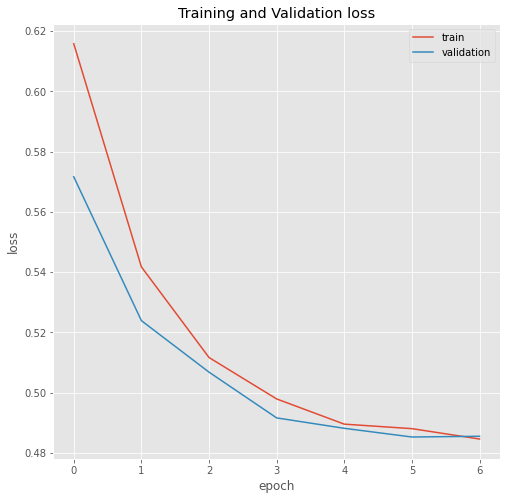

In [15]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
model.evaluate(X_train, y_train, verbose=False)


[0.47785547375679016,
 0.7793022990226746,
 0.7638116478919983,
 0.7018739581108093]

In [17]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=False)

In [18]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       358        68
Positive        95       241

In [19]:
results

Value
Accuracy   0.786089
Precision  0.779935
FPR        0.159624
Recall     0.717262
F1         0.747287

## Summary

- Accuracy and precision increased by just 1%
- Recall also improved by 2%
- F1 has also slightly increased
- This model is slightly better than the keras embedding layer model

### explore

- try and find a location in a tweet text and see if we can match that to the location column.
- be careful with places like east london.
- see if the user is within the radius of the location in the tweet itself(i.e. if a user retweets from melville about a tweet in braamfontein it could be legit, but it is not if the user is in london).

- tweets with mislabels: exclude these since they might hurt our model.


### Word2vec

In [10]:
from gensim.models import Word2Vec, KeyedVectors

In [11]:
data2 = data_without_tockenization.copy()

In [12]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [13]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [14]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [15]:

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []

for arr in tweet_data:
    tweet_data_array.append(arr)

In [19]:
# train word2vec model
model = Word2Vec(sentences=tweet_data_array, size=100, window=5, workers=3, min_count=1,
                 negative=20, iter=100,seed=1000,sg=0)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))
    
# save model in ASCII (word2vec) format
filename = './Embedding_Models/embedding_word2vec100iterCBOW.txt'
model.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 2590


In [20]:
# load embedding as a dict
def load_embedding(filename):
# load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [21]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [22]:

# load embedding from file
raw_embedding = load_embedding('./Embedding_Models/embedding_word2vec100iterCBOW.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [25]:
from keras import layers
# define model
model = Sequential()
model.add(embedding_layer)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1539700   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,540,721
Trainable params: 1,021
Non-trainable params: 1,539,700
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=16,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
386/386 [==============================] - 4s 10ms/step - loss: 0.6347 - accuracy: 0.6469 - precision: 0.5959 - recall: 0.5363 - val_loss: 0.5547 - val_accuracy: 0.7259 - val_precision: 0.7071 - val_recall: 0.6513
Epoch 2/50
386/386 [==============================] - 2s 6ms/step - loss: 0.5355 - accuracy: 0.7388 - precision: 0.7086 - recall: 0.6591 - val_loss: 0.5381 - val_accuracy: 0.7464 - val_precision: 0.7211 - val_recall: 0.6974
Epoch 3/50
386/386 [==============================] - 2s 6ms/step - loss: 0.5143 - accuracy: 0.7609 - precision: 0.7343 - recall: 0.6891 - val_loss: 0.5352 - val_accuracy: 0.7536 - val_precision: 0.7385 - val_recall: 0.6875
Epoch 4/50
386/386 [==============================] - 2s 6ms/step - loss: 0.5065 - accuracy: 0.7640 - precision: 0.7398 - recall: 0.6895 - val_loss: 0.5289 - val_accuracy: 0.7595 - val_precision: 0.7491 - val_recall: 0.6875
Epoch 5/50
386/386 [==

In [27]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       313       113
Positive        96       240

In [28]:
results

Value
Accuracy   0.725722
Precision  0.679887
FPR        0.265258
Recall     0.714286
F1         0.696662

- performance is bad when the number of iterations is low
- skip gram is better for learning infrequent words
    - In CBOW the vectors from the context words are averaged before predicting the center word.
    - In skip-gram there is no averaging of embedding vectors 
    - It seems like the model can learn better representations for the rare words when their vectors are not   averaged with the other context words in the process of making the predictions.
- This dataset is composed of mostly repeating words, especially the keywords that are used to extract tweets, therefore it is probably better to use CBOW.
- CBOW does also yield a better performance.
- Pre-trained embeddings have less trainable parameters than the keras embedding layer 

**30 iterations**
- CBOW: 59 F1, 69.9 ACC
- SG: 68 F1, 73.6 ACC


**50 iterations**
- CBOW: 69 F1, 72 ACC
- SG: 64 F1, 70 ACC

**100 iterations**
- CBOW: 67 F1, 72 ACC
- SG: 63 F1, 72 ACC

# Simple RNN +  Word2vec

In [36]:

# load embedding from file
raw_embedding = load_embedding('./Embedding_Models/embedding_word2vec100iterCBOW.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [87]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 23, 100)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 23, 128)           29312     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,581,429
Trainable params: 41,729
Non-trainable params: 1,539,700
_______________________________________

In [92]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=16,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

Epoch 1/50
386/386 [==============================] - 29s 76ms/step - loss: 0.6386 - accuracy: 0.6730 - val_loss: 0.6440 - val_accuracy: 0.6618
Epoch 2/50
386/386 [==============================] - 29s 74ms/step - loss: 0.6363 - accuracy: 0.6736 - val_loss: 0.6313 - val_accuracy: 0.6735
Epoch 3/50
386/386 [==============================] - 29s 75ms/step - loss: 0.6133 - accuracy: 0.7030 - val_loss: 0.5997 - val_accuracy: 0.7128
Epoch 4/50
386/386 [==============================] - 29s 76ms/step - loss: 0.6126 - accuracy: 0.7009 - val_loss: 0.6036 - val_accuracy: 0.7085
Epoch 5/50
386/386 [==============================] - 28s 74ms/step - loss: 0.6131 - accuracy: 0.7002 - val_loss: 0.6037 - val_accuracy: 0.7085
Epoch 6/50
386/386 [==============================] - 29s 74ms/step - loss: 0.6114 - accuracy: 0.7035 - val_loss: 0.6051 - val_accuracy: 0.7085
Epoch 7/50
386/386 [==============================] - 29s 76ms/step - loss: 0.6108 - accuracy: 0.7041 - val_loss: 0.6043 - val_accuracy:

In [ ]:
model_w2vRNN = model.to_json()
with open('./NN_Models/word2vec_RNN_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('./NN_Models/word2vec_RNN_model.h5')

print('saved model!')

In [93]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Negative  Positive
Negative       334        92
Positive        92       244

In [94]:
results

Value
Accuracy   0.758530
Precision  0.726190
FPR        0.215962
Recall     0.726190
F1         0.726190

# LSTM +  Word2vec

In [37]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 23, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 23, 128)           117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,706,421
Trainable params: 166,721
Non-trainable params: 1,539,700
______________________________________

In [38]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=16,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

Epoch 1/50
386/386 [==============================] - 34s 87ms/step - loss: 0.5285 - accuracy: 0.7518 - val_loss: 0.5035 - val_accuracy: 0.7653
Epoch 2/50
386/386 [==============================] - 32s 82ms/step - loss: 0.4804 - accuracy: 0.7861 - val_loss: 0.4945 - val_accuracy: 0.7609
Epoch 3/50
386/386 [==============================] - 33s 84ms/step - loss: 0.4557 - accuracy: 0.7963 - val_loss: 0.4857 - val_accuracy: 0.7711
Epoch 4/50
386/386 [==============================] - 32s 82ms/step - loss: 0.4325 - accuracy: 0.8139 - val_loss: 0.4711 - val_accuracy: 0.7857
Epoch 5/50
386/386 [==============================] - 35s 91ms/step - loss: 0.4145 - accuracy: 0.8224 - val_loss: 0.4885 - val_accuracy: 0.7901
Epoch 6/50
386/386 [==============================] - 31s 81ms/step - loss: 0.3978 - accuracy: 0.8287 - val_loss: 0.4878 - val_accuracy: 0.7930
Epoch 7/50
386/386 [==============================] - 31s 80ms/step - loss: 0.3749 - accuracy: 0.8423 - val_loss: 0.4787 - val_accuracy:

In [39]:
model_w2vRNN = model.to_json()
with open('./NN_Models/word2vec_LSTM_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('./NN_Models/word2vec_LSTM_model.h5')

print('saved model!')

saved model!


In [40]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Negative  Positive
Negative       336        90
Positive        91       245

In [41]:
results

Value
Accuracy   0.762467
Precision  0.731343
FPR        0.211268
Recall     0.729167
F1         0.730253

# Bidirectional LSTM + Word2Vec

In [23]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 23, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,938,677
Trainable params: 398,977
Non-trainable params: 1,539,700
______________________________________

In [24]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=16,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

Epoch 1/50
386/386 [==============================] - 53s 137ms/step - loss: 0.5093 - accuracy: 0.7565 - val_loss: 0.4838 - val_accuracy: 0.7697
Epoch 2/50
386/386 [==============================] - 51s 132ms/step - loss: 0.4589 - accuracy: 0.7927 - val_loss: 0.4616 - val_accuracy: 0.7784
Epoch 3/50
386/386 [==============================] - 51s 132ms/step - loss: 0.4253 - accuracy: 0.8101 - val_loss: 0.4729 - val_accuracy: 0.7901
Epoch 4/50
386/386 [==============================] - 51s 131ms/step - loss: 0.3994 - accuracy: 0.8279 - val_loss: 0.4787 - val_accuracy: 0.7930
Epoch 5/50
386/386 [==============================] - 52s 135ms/step - loss: 0.3695 - accuracy: 0.8423 - val_loss: 0.4778 - val_accuracy: 0.7959
Epoch 6/50
386/386 [==============================] - 51s 133ms/step - loss: 0.3479 - accuracy: 0.8501 - val_loss: 0.4739 - val_accuracy: 0.7857
Epoch 7/50
386/386 [==============================] - 52s 134ms/step - loss: 0.3206 - accuracy: 0.8647 - val_loss: 0.5127 - val_ac

In [25]:
model_w2vBLSTM = model.to_json()
with open('./NN_Models/word2vec_BLSTM_model.json', 'w') as json_file:
    json_file.write(model_w2vBLSTM)

model.save_weights('./NN_Models/word2vec_BLSTM_model.h5')

print('saved model!')

saved model!


In [26]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       327        99
Positive       100       236

In [27]:
results

Value
Accuracy   0.738845
Precision  0.704478
FPR        0.232394
Recall     0.702381
F1         0.703428

### Glove

In [20]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           769850    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 128)          22912     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 805,179
Trainable params: 35,329
Non-trainable params: 769,850
___________________________________________

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

In [ ]:
results